In [1]:
!git clone 'https://github.com/shilpiprd/Biparietal_Occipitofrontal-Diameter-Detection.git'
%cd /content/Biparietal_Occipitofrontal-Diameter-Detection/task2/

Cloning into 'Biparietal_Occipitofrontal-Diameter-Detection'...
remote: Enumerating objects: 1255, done.
remote: Counting objects: 100% (628/628), done.
remote: Compressing objects: 100% (626/626), done.
remote: Total 1255 (delta 2), reused 627 (delta 2), pack-reused 627
Receiving objects: 100% (1255/1255), 81.36 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/Biparietal_Occipitofrontal-Diameter-Detection/task2


In [2]:
!ls

images	masks


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from PIL import Image, ImageOps
import scipy.ndimage
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

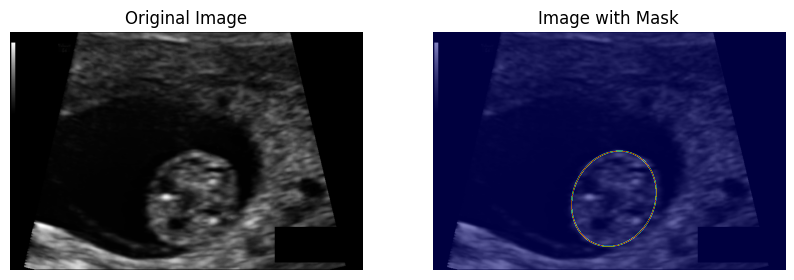

In [4]:
#perfrom visualizatin on normal image and mask
def visualize_image_and_mask(image, mask):
    if image.size != mask.size:
        raise ValueError(f"Image and mask shapes do not match: {image.size} vs {mask.size}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', aspect='equal')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray', aspect='equal')
    plt.imshow(mask, alpha=0.5, cmap='jet', aspect='equal')
    plt.title("Image with Mask")
    plt.axis('off')
    plt.show()

random_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/images/000_HC.png').convert('L')
random_mask = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/masks/000_HC_Annotation.png').convert('L')
random_image = np.array(random_image) / 255.0
random_mask = np.array(random_mask) / 255.0

visualize_image_and_mask(random_image, random_mask)


<ipython-input-5-40091b3dff87>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


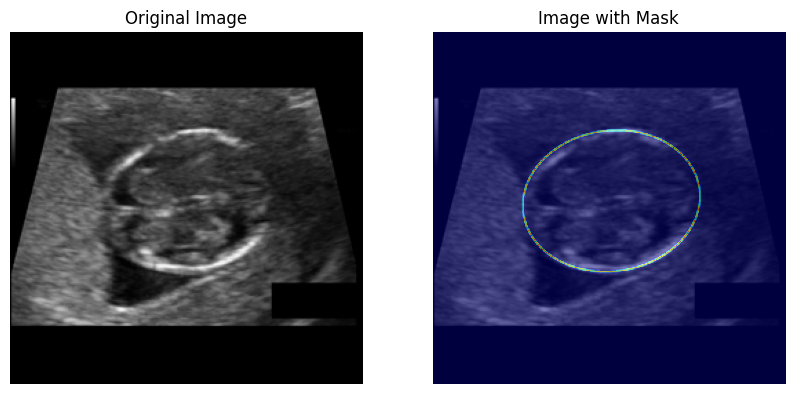

In [5]:
#scale the image and mask and visualize it
def resize_image_with_padding(img, target_size):
    aspect_ratio = img.width / img.height
    if target_size[0] / target_size[1] > aspect_ratio:
        new_height = target_size[1]
        new_width = round(new_height * aspect_ratio)
    else:
        new_width = target_size[0]
        new_height = round(new_width / aspect_ratio)

    resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)

    padded_image = Image.new('L', target_size, 0)

    padding_top = (target_size[1] - new_height) // 2
    padding_left = (target_size[0] - new_width) // 2
    padded_image.paste(resized_image, (padding_left, padding_top))

    return padded_image, (padding_left, padding_top, new_width, new_height)

random_original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/images/021_HC.png').convert('L')
random_original_mask = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/masks/021_HC_Annotation.png').convert('L')
target_size = (256, 256)
resized_image, image_padding_info= resize_image_with_padding(random_original_image, target_size)
resized_mask, mask_padding_info = resize_image_with_padding(random_original_mask, target_size)
visualize_image_and_mask(resized_image, resized_mask)


<b>The mask matches the image properly after resizing</b>

In [6]:
#check if the path of iamges are loaded correctly
base_image_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/images/'
image_paths = os.listdir(base_image_path)
base_mask_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/masks/'
mask_paths = os.listdir(base_mask_path)
count = 0
image_paths = sorted([img for img in image_paths if img.endswith('.png')])
mask_paths = sorted([msk for msk in mask_paths if msk.endswith('_Annotation.png')])
for p1, p2 in zip(image_paths, mask_paths):
    if(count == 5):
        break
    print(p1, p2)
    count += 1

000_HC.png 000_HC_Annotation.png
001_HC.png 001_HC_Annotation.png
002_HC.png 002_HC_Annotation.png
003_HC.png 003_HC_Annotation.png
004_HC.png 004_HC_Annotation.png


In [7]:
#perform scaling on all iamges and mask and store it in feature dictioanry
feature_dictionary = {'image_path':[], 'mask_path':[], 'image': [], 'mask': []}

for image_path, mask_path in zip(image_paths, mask_paths):
    full_image_path = os.path.join(base_image_path, image_path)
    full_mask_path = os.path.join(base_mask_path, mask_path)
    image = Image.open(full_image_path).convert('L')
    mask = Image.open(full_mask_path).convert('L')
    target_size = (256, 256)
    resized_image, padding_image_info= resize_image_with_padding(image, target_size)
    resized_mask, padding_mask_info = resize_image_with_padding(mask, target_size)
    feature_dictionary['image_path'].append(full_image_path)
    feature_dictionary['mask_path'].append(full_mask_path)
    feature_dictionary['image'].append(np.array(resized_image) / 255.0)
    feature_dictionary['mask'].append(np.array(resized_mask) / 255.0)

<ipython-input-5-40091b3dff87>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


622
/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/images/000_HC.png
/content/Biparietal_Occipitofrontal-Diameter-Detection/task2/masks/000_HC_Annotation.png


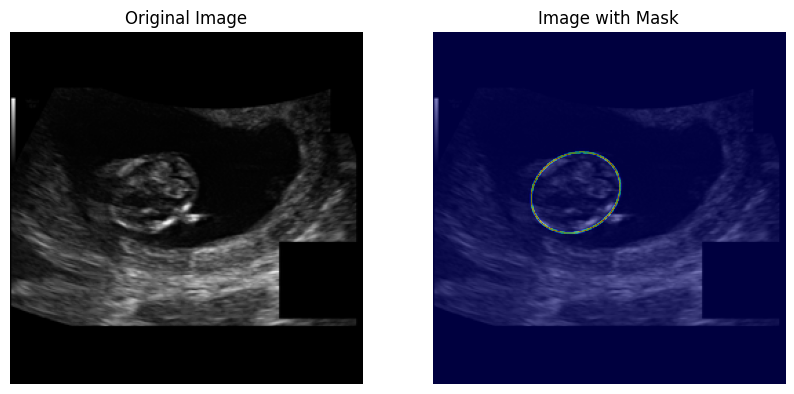

In [8]:
#take a random image and mask from feature_dictionary and plot it
print(len(image_paths)) #total no. of image,mask pair we've: 622
print(feature_dictionary['image_path'][0])
print(feature_dictionary['mask_path'][0])
fea_ran_img = feature_dictionary['image'][5]
fea_ran_mask = feature_dictionary['mask'][5]
visualize_image_and_mask(fea_ran_img, fea_ran_mask)

In [9]:
#perform split_train_test part
x = feature_dictionary['image']
y = feature_dictionary['mask']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
print(len(xtrain), len(xtest))
print(len(ytrain), len(ytest)) #497 + 125 = 622
print(type(xtrain), type(ytrain), type(xtest), type(ytest))

497 125
497 125
<class 'list'> <class 'list'> <class 'list'> <class 'list'>


In [11]:
#create data loader to matintain pytorch standards
SEED = 1
X_train_tensor = torch.tensor(xtrain, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.tensor(ytrain, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
X_test_tensor = torch.tensor(xtest, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(ytest, dtype=torch.float32).unsqueeze(1)

mean, std = 0.5, 0.5  #Using Standard values
X_train_normalized = (X_train_tensor - mean) / std
X_test_normalized = (X_test_tensor - mean) / std

# Create TensorDataset
train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

# CUDA check
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict( batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Creaing DataLoaders
train_loader = DataLoader(train_dataset,shuffle = True, **dataloader_args)
test_loader = DataLoader(test_dataset,shuffle = False,  **dataloader_args)

<ipython-input-11-842f2fb10bda>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train_tensor = torch.tensor(xtrain, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension


CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
#traidtional unet architecture
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))

        # Decoder
        xu3 = self.upconv3(xe42)
        xu33 = torch.cat([xu3, xe32], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu2 = self.upconv2(xd32)
        xu22 = torch.cat([xu2, xe22], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu1 = self.upconv1(xd22)
        xu11 = torch.cat([xu1, xe12], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        # Output layer
        out = self.outconv(xd12)
        return out

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(1).to(device)

# Print model summary
from torchsummary import summary
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
            Conv2d-2         [-1, 32, 256, 256]           9,248
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
            Conv2d-5         [-1, 64, 128, 128]          36,928
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
            Conv2d-8          [-1, 128, 64, 64]         147,584
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
           Conv2d-11          [-1, 256, 32, 32]         590,080
  ConvTranspose2d-12          [-1, 128, 64, 64]         131,200
           Conv2d-13          [-1, 128, 64, 64]         295,040
           Conv2d-14          [-1, 128,

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def calculate_iou(output, target):
    smooth = 1e-6  # To avoid division by zero
    output = torch.sigmoid(output)
    output = (output > 0.5).bool()

    target_bool = target.bool()

    intersection = (output & target_bool).sum((1, 2))
    union = (output | target_bool).sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_iou = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Initialize optimizer
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)
        total_loss += loss.item() * data.size(0)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Calculate IoU
        total_iou += calculate_iou(y_pred, target)

    average_loss = total_loss / len(train_loader.dataset)
    average_iou = total_iou / len(train_loader)

    print(f'Training set: Average loss: {average_loss:.4f}, Average IoU: {average_iou * 100:.2f}%')

    return train_losses

def test(model, device, test_loader, criterion):
    test_loss=0
    model.eval()
    total_iou = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            total_iou += calculate_iou(output, target)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    average_iou = total_iou / len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Average Pixel Accuracy: {:.2f}%\n'.format(test_loss, average_iou * 100))

    return test_loss, test_losses

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 20)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_losses = test(model, device, test_loader, criterion)
    scheduler.step(test_loss)

EPOCH: 0
Training set: Average loss: 0.0119, Average IoU: 10.24%

Test set: Average loss: 0.0056, Average Pixel Accuracy: 43.40%

EPOCH: 1
Training set: Average loss: 0.0048, Average IoU: 34.48%

Test set: Average loss: 0.0033, Average Pixel Accuracy: 2.42%

EPOCH: 2
Training set: Average loss: 0.0034, Average IoU: 2.34%

Test set: Average loss: 0.0032, Average Pixel Accuracy: 2.42%

EPOCH: 3
Training set: Average loss: 0.0031, Average IoU: 5.00%

Test set: Average loss: 0.0032, Average Pixel Accuracy: 3.84%

EPOCH: 4
Training set: Average loss: 0.0031, Average IoU: 2.43%

Test set: Average loss: 0.0032, Average Pixel Accuracy: 2.42%

EPOCH: 5
Training set: Average loss: 0.0031, Average IoU: 2.35%

Test set: Average loss: 0.0032, Average Pixel Accuracy: 2.42%

EPOCH: 6
Training set: Average loss: 0.0031, Average IoU: 2.35%

Test set: Average loss: 0.0032, Average Pixel Accuracy: 2.42%

EPOCH: 7
Training set: Average loss: 0.0031, Average IoU: 2.34%

Test set: Average loss: 0.0032, Aver

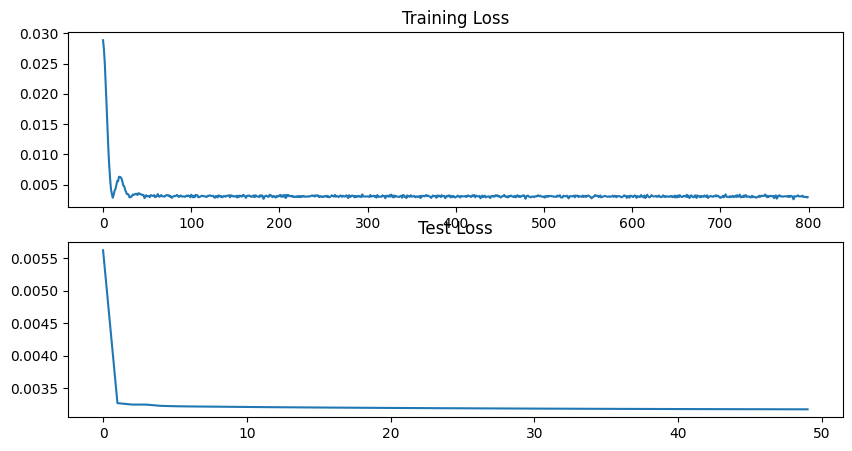

In [15]:
#now plot the loss , accuracy graph
train_loss_values = [loss.item() if not isinstance(loss, float) else loss for loss in train_losses]
test_loss_values = [loss if isinstance(loss, float) else loss.item() for loss in test_losses]
fig, axs = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column for subplots
axs[0].plot(train_loss_values)
axs[0].set_title("Training Loss")
axs[1].plot(test_loss_values)
axs[1].set_title("Test Loss")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


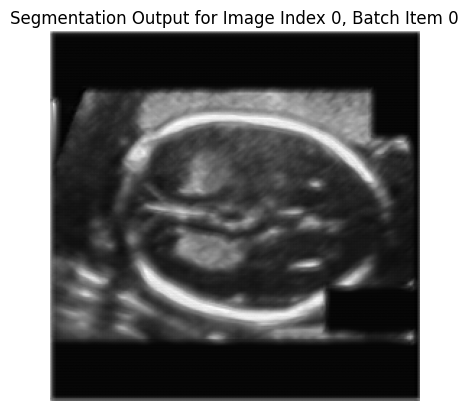

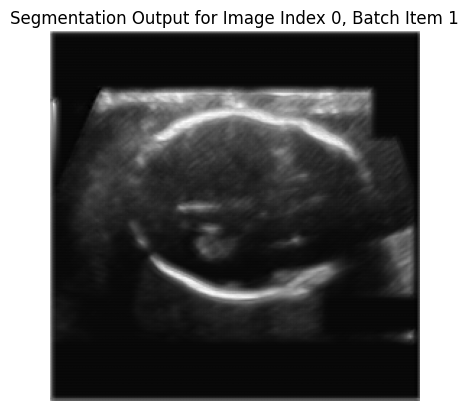

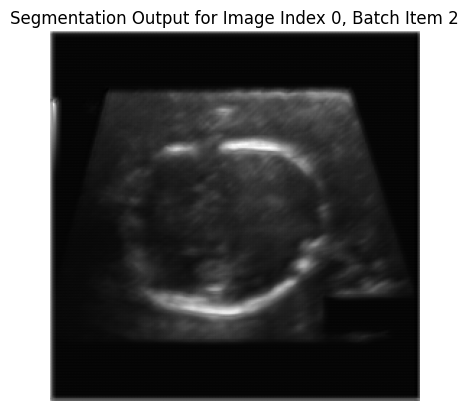

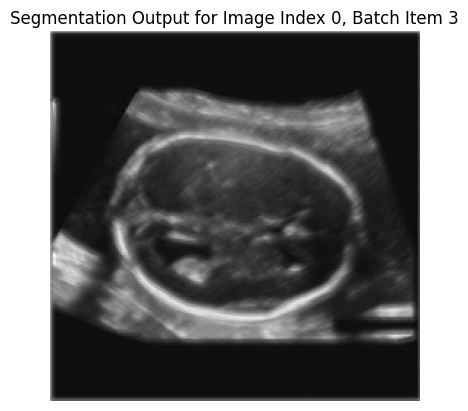

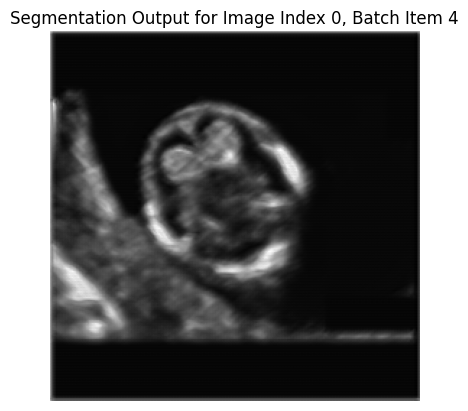

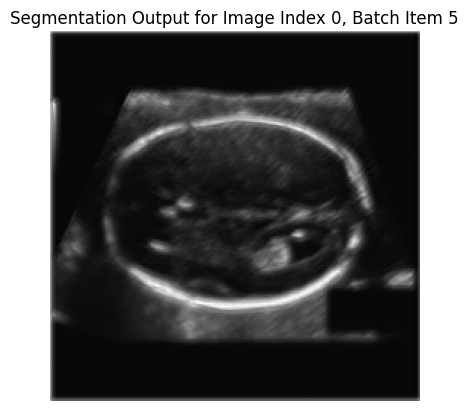

In [19]:
# def pos_process_mask(mask): [ not finished]
#         ...

#def extract_biometry_points(mask, threshold = 0.5): [ not finished]
#        ...
count = 0
for index, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
      output_segmentation = model(data).sigmoid()
      output_segmentation = output_segmentation.cpu().detach().numpy()

      for i in range(data.size(0)):
          single_output_segmentation = output_segmentation[i].squeeze()
          if(count <= 5):
              plt.imshow(single_output_segmentation, cmap='gray')
              plt.title(f"Segmentation Output for Image Index {index}, Batch Item {i}")
              plt.axis('off')
              plt.show()
              count += 1

In [20]:
# Save the model state dictionary
model_save_path = 'model2_weights.pth'
torch.save(model.state_dict(), model_save_path)